In [1]:
import json
import copy
import os
import sys
from functools import partial

import numpy as np
import pandas as pd
from scipy import optimize

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib.gridspec as gridspec

sys.path.append('/Users/dsommer/Dropbox/scratch/pycct/pycct')
from pycct.defect_thermodynamics import DefectThermodynamics

import warnings
warnings.filterwarnings(action='once')

PARAMETERS = '../parameters/'

light_grey = '#EEEEEE'
lighter_grey = '#F5F5F5'
markers = ['d', 'P', 'o']
colors = ['#74a9cf','#0570b0','#023858']
font = {'size': 16}
linewidth = 2
markersize = 2

# Example 1
### Basic Usage

Create instance of DefectThermodynamics class, named 'test_thermo', from .json parameter file containing CdTe data.

In [3]:
excluded_defects  = [ "V_Cd+Te_Cd", "Te_int+Te_int", "Te_int+Te_Cd",
                      "As_Te", 
                      "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd",
                      "Cu_Cd", "Cu_int", "Cu_Cd+Cd_int", "Cu_Cd+Cu_int"]

test_thermo = DefectThermodynamics.from_json(os.path.join(PARAMETERS, 'params_CdTe_Wei_FS.json'),
                                             excluded_defects=excluded_defects)

Plot (stable) defect formation energies versus $E_\mathrm{Fermi}$ for given chemical potentials, $\Delta \mu$.

/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


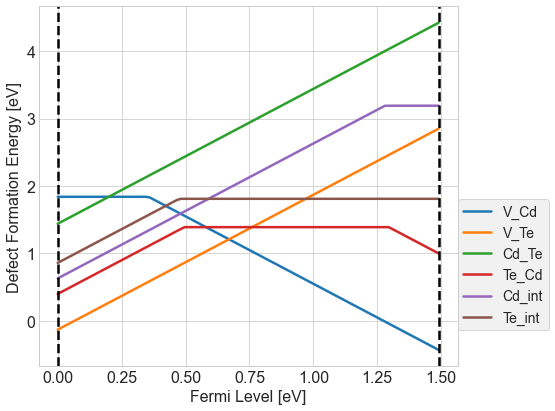

In [5]:
chem_pots = [-1.15, 0, 0, 0, 0, 0]
plt = test_thermo.formation_energy_plot(chem_pots)
plt.show()

Convenient data visulaization for defeect formation energies and concentrations usings pandas DataFrames.

In [6]:
dfdf = test_thermo.formation_energies_dataframe(chem_pots, Efermi=0.5) 
print('Defect formation energies [eV]:\n')
print(dfdf)
print(10*'-')

dfdc = test_thermo.defect_concentrations_dataframe(chem_pots, Efermi=0.5, temperature=300) 
print('Defect concentrations [cm^-3]:\n')
print(dfdc)

Defect formation energies [eV]:

        V_Cd  V_Te  Cd_Te  Te_Cd  Cd_int  Te_int
charge                                          
-3       NaN   NaN    NaN    NaN     NaN     NaN
-2      1.55   NaN    NaN   2.98     NaN     NaN
-1      2.19   NaN    NaN    NaN     NaN     NaN
 0      1.84   NaN    NaN   1.39    3.19    1.81
 1       NaN   NaN    NaN   1.72     NaN     NaN
 2       NaN  0.87   2.44   1.40    1.63    1.86
 3       NaN   NaN    NaN    NaN     NaN     NaN
 4       NaN   NaN    NaN    NaN     NaN     NaN
----------
Defect concentrations [cm^-3]:

                V_Cd          V_Te         Cd_Te         Te_Cd        Cd_int  \
charge                                                                         
-3      0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
-2      1.283902e-04  0.000000e+00  0.000000e+00  1.217837e-28  0.000000e+00   
-1      2.275124e-15  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
 0      1.724830e-09  0.000000e+00

/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Get atomic fractions following from defect formation.

In [8]:
afs = test_thermo.atomic_fractions(chem_pots, Efermi=0.5, temperature=1000)
print(f'Atomic fractions: {afs}')


Atomic fractions: [0.50001021 0.         0.49998979 0.         0.         0.        ]


Find self-consistent, equilibrium Fermi level and correspong free carrier concentrations.

In [10]:
efermi = test_thermo.solve_for_fermi_energy(chem_pots, temperature=1000)
print(f'Fermi level: {efermi:.2f} eV')

h_tmp, e_tmp = test_thermo.charge_carriers(efermi, temperature=1000)
print(f'Hole concentration: {h_tmp:.2e} cm^-3')
print(f'Electron concentration: {e_tmp:.2e} cm^-3')

Fermi level: 0.70 eV
Hole concentration: 3.47e+16 cm^-3
Electron concentration: 4.69e+14 cm^-3


Find non-equilibrium Fermi level following quench using frozen-in approximation.

In [11]:
high_temp, low_temp = 1000, 300
efq_low = test_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, low_temp, high_temp)
print(f'Fermi level: {efq_low:.2f} eV')

Fermi level: 0.34 eV


Find corresponding defect concentrations following quench (frozen-in approximation).

In [12]:
high_temp, low_temp = 1000, 300
ef_high = test_thermo.solve_for_fermi_energy(chem_pots, high_temp)
high_temp_conc = test_thermo.defect_concentrations(chem_pots, ef_high, high_temp)
efq_low = test_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, low_temp, high_temp)
low_temp_conc = test_thermo.redistribute_defect_charge_states(high_temp_conc, efq_low, low_temp)
print(f'Defect concentrations [cm^-3]: \n {low_temp_conc}')

Defect concentrations [cm^-3]: 
 [[0.00000000e+00 6.96316680e+15 5.05756340e+07 1.57160675e+16
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 5.53412153e+15 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 6.77012895e+07 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.42300619e-22 0.00000000e+00 1.22843968e+10
  1.43965744e+07 1.40179303e+15 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 3.02446572e-20
  0.00000000e+00 8.18121668e+11 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 4.38860707e+08
  0.00000000e+00 1.06582605e+13 0.00000000e+00 0.00000000e+00]]


Extract binding energy for $(\mathrm{V_{Cd}+Te_{Cd}})^0$ and quasi-chemical mass action constant for $\mathrm{V_{Cd}}^{-2} + \mathrm{Te_{Cd}}^{+2}\rightarrow (\mathrm{V_{Cd}+Te_{Cd}})^0$

In [13]:
extrinsic_defects  = ["As_Te", 
                      "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd",
                      "Cu_Cd", "Cu_int", "Cu_Cd+Cd_int", "Cu_Cd+Cu_int"]

test_thermo = DefectThermodynamics.from_json(os.path.join(PARAMETERS, 'params_CdTe_Wei_FS.json'),
                                             excluded_defects=extrinsic_defects)

dfdf = test_thermo.formation_energies_dataframe(chem_pots, Efermi=0.5) 
E_bind = dfdf['V_Cd+Te_Cd'][0] - dfdf['V_Cd'].loc[-2] - dfdf['Te_Cd'].loc[2]
print(f'Binding energy: {E_bind:.2f} eV')

dfdc = test_thermo.defect_concentrations_dataframe(chem_pots, Efermi=0.5, temperature=300) 
kma = dfdf['V_Cd+Te_Cd'][0] / (dfdf['V_Cd'].loc[-2] * dfdf['Te_Cd'].loc[2])
print(f'Reaction constant: {kma:.2f}')

Binding energy: -0.47 eV
Reaction constant: 1.14


# Example 2
### Reproduce Figures 2 and 3 from [PRB 90, 245202 (2014)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.90.245202)

In [15]:
def defect_label_formatter(defect_string):
    comps = defect_string.split('_')
    new_string = f'{comps[0]}$_\mathrm{{{comps[1]}}}^{{{comps[2]}}}$'
    return new_string

In [16]:
extrinsic_defects  = ["V_Cd+Te_Cd", "Te_int+Te_int", "Te_int+Te_Cd",
                      "As_Te", 
                      "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd",
                      "Cu_Cd", "Cu_int", "Cu_Cd+Cd_int", "Cu_Cd+Cu_int"]

test_thermo = DefectThermodynamics.from_json(os.path.join(PARAMETERS, 'params_CdTe_Wei_FS.json'),
                                             excluded_defects=extrinsic_defects)

dfdc = test_thermo.defect_concentrations_dataframe(chem_pots, 0.0, 300) 
dfdc

,V_Cd,V_Te,Cd_Te,Te_Cd,Cd_int,Te_int
charge,,,,,,
-3,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
-2,2.038315e-21,0.000000e+00,0.000000,1.933431e-45,0.000000e+00,0.000000e+00
-1,9.065145e-24,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
0,1.724830e-09,0.000000e+00,0.000000,6.257683e-02,3.611973e-32,5.504579e-09
1,0.000000e+00,0.000000e+00,0.000000,4.490429e+01,0.000000e+00,0.000000e+00
2,0.000000e+00,2.144321e+24,0.009046,2.677205e+15,3.663124e+11,5.012123e+07
3,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00
4,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00


Loop over $\Delta \mu_\mathrm{Cd} \in [-1.15, 0]$ eV, the stable existence region of CdTe

In [17]:
temperature = 873
final_temperature = 300
muCds = np.linspace(-1.15, 0, 100)

nholes = np.zeros(muCds.shape)
nelectrons = np.zeros(muCds.shape)
efermis = np.zeros(muCds.shape)

defect_concentrations = {
                         "V_Cd": {"0": np.zeros(muCds.shape),
                                  "-1": np.zeros(muCds.shape),
                                  "-2": np.zeros(muCds.shape)},
                         "V_Te": {"2": np.zeros(muCds.shape)},
                         "Cd_Te": {"2": np.zeros(muCds.shape)},
                         "Te_Cd": {"0": np.zeros(muCds.shape), 
                                   "1": np.zeros(muCds.shape),
                                   "2": np.zeros(muCds.shape)},
                         "Te_int": {"0": np.zeros(muCds.shape), "2": np.zeros(muCds.shape)},
#                          "V_Cd+Te_Cd": {"0": np.zeros(muCds.shape)}, 
#                          "Te_int+Te_int": {"2": np.zeros(muCds.shape), "3": np.zeros(muCds.shape)}, 
#                          "Te_int+Te_Cd": {"0": np.zeros(muCds.shape), "2": np.zeros(muCds.shape)}
                        }

nholes_quench = np.zeros(muCds.shape)
nelectrons_quench = np.zeros(muCds.shape)
efermis_quench = np.zeros(muCds.shape)

defect_concentrations_quench = copy.deepcopy(defect_concentrations)


for i, mucd in enumerate(muCds):
    chem_pots = [mucd, 0, -1.15-mucd, 0, 0, -1]
    ef_tmp = test_thermo.solve_for_fermi_energy(chem_pots, temperature)
    h_tmp, e_tmp = test_thermo.charge_carriers(ef_tmp, temperature)
    
    df_tmp = test_thermo.defect_concentrations_dataframe(chem_pots, ef_tmp, temperature)
    for dlabel, dconc_dict in defect_concentrations.items():
        for qstate, dconc in dconc_dict.items():
            dconc[i] = df_tmp[dlabel].loc[int(qstate)]
        
    nholes[i] = h_tmp
    nelectrons[i] = e_tmp
    efermis[i] = ef_tmp
                           
    ### Quench to 300 K
    high_temp_conc = test_thermo.defect_concentrations(chem_pots, ef_tmp, temperature)
    efq_tmp = test_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, final_temperature, temperature)
    hq_tmp, eq_tmp = test_thermo.charge_carriers(efq_tmp, final_temperature)
    
    low_temp_conc = test_thermo.redistribute_defect_charge_states(high_temp_conc, efq_tmp, final_temperature)
    for j, (dlabel, dconc_dict) in enumerate(defect_concentrations_quench.items()):
        for qstate, dconc in dconc_dict.items():
            dconc[i] = low_temp_conc[j][int(qstate) + 3]
                          
    nholes_quench[i] = hq_tmp
    nelectrons_quench[i] = eq_tmp
    efermis_quench[i] = efq_tmp


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


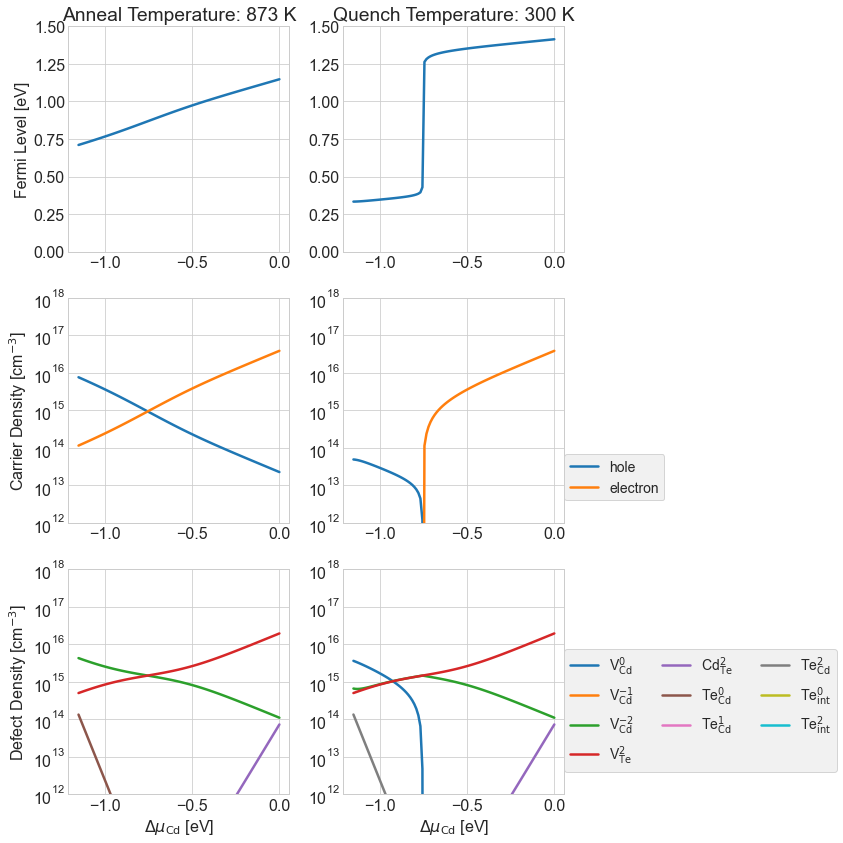

In [18]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(3)]


axes[0][0].plot(muCds, efermis, label=None,
                linestyle='-', linewidth=2.5)
axes[0][1].plot(muCds, efermis_quench, label=None,
                linestyle='-', linewidth=2.5)

axes[0][0].set_ylim((0.0,1.5))
axes[0][1].set_ylim((0.0,1.5))
axes[0][0].set_ylabel(r'Fermi Level [eV]')
axes[0][0].set_title(f'Anneal Temperature: {temperature} K')
axes[0][1].set_title(f'Quench Temperature: {final_temperature} K')



axes[1][0].plot(muCds, nholes, label='hole',
                linestyle='-', linewidth=2.5)
axes[1][0].plot(muCds, nelectrons, label='electron',
                linestyle='-', linewidth=2.5)
axes[1][1].plot(muCds, nholes_quench, label='hole',
                linestyle='-', linewidth=2.5)
axes[1][1].plot(muCds, nelectrons_quench, label='electron',
                linestyle='-', linewidth=2.5)

axes[1][0].set_yscale('log')
axes[1][1].set_yscale('log')

axes[1][0].set_ylim((1e12,1e18))
axes[1][1].set_ylim((1e12,1e18))

axes[1][0].set_ylabel(r'Carrier Density [cm$^{-3}$]')
axes[1][1].legend(loc=(1,0.1), frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)




for dlabel, dconc_dict in defect_concentrations.items():
    for qstate, dconc in dconc_dict.items():
        new_label = defect_label_formatter(dlabel + '_' + qstate)
        axes[2][0].plot(muCds, dconc, label=new_label,
                        linestyle='-', linewidth=2.5)
for dlabel, dconc_dict in defect_concentrations_quench.items():
    for qstate, dconc in dconc_dict.items():
        new_label = defect_label_formatter(dlabel + '_' + qstate)
        axes[2][1].plot(muCds, dconc, label=new_label,
                        linestyle='-', linewidth=2.5)

axes[2][0].set_yscale('log')
axes[2][1].set_yscale('log')

axes[2][0].set_ylim((1e12,1e18))
axes[2][1].set_ylim((1e12,1e18))
    
axes[2][0].set_ylabel(r'Defect Density [cm$^{-3}$]')
axes[2][1].legend(loc=(1,0.1), frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=3)

axes[2][0].set_xlabel(r'$\Delta \mu_\mathrm{Cd}$ [eV]')
axes[2][1].set_xlabel(r'$\Delta \mu_\mathrm{Cd}$ [eV]')



plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()



# Example 2
### Formation Energies of As, Cu, and Cl dopants from [JAP 118, 025102 (2015)](https://aip.scitation.org/doi/full/10.1063/1.4926748), [APL 111, 042106 (2017)](https://aip.scitation.org/doi/full/10.1063/1.4986077), and [JAP 119, 045104 (2016)](https://aip.scitation.org/doi/full/10.1063/1.4940722)

/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,As_Te,Cl_Te,Cl_int,Cl_Te+V_Cd,Cl_int+V_Cd,Cu_Cd,Cu_int
charge,,,,,,,
-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-1,1.37,NaN,1.46,2.04,2.18,0.22,NaN
0,2.06,1.99,2.07,2.70,2.78,0.84,2.18
1,2.21,1.52,1.58,NaN,NaN,NaN,1.63
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


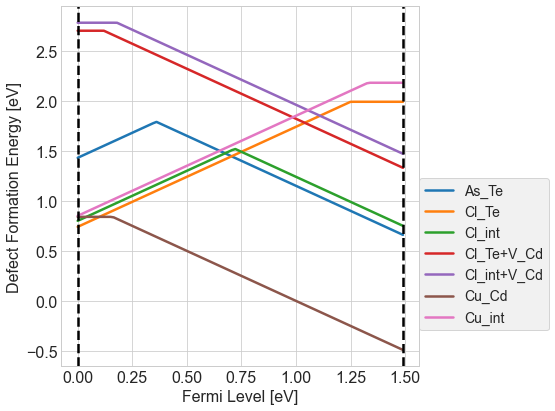

In [19]:
intrinsic_defects = ["V_Cd", "V_Te", "Cd_Te", "Te_Cd", "Cd_int", "Te_int",
                    "V_Cd+Te_Cd", "Te_int+Te_int", "Te_int+Te_Cd",
                    "Cu_Cd+Cd_int", "Cu_Cd+Cu_int"]

test_thermo = DefectThermodynamics.from_json(os.path.join(PARAMETERS, 'params_CdTe_Wei_FS.json'),
                                             excluded_defects=intrinsic_defects)

chem_pots = [-1.15, 0, 0, -0.25, 1.53, -1.22]
plt = test_thermo.formation_energy_plot(chem_pots)

test_thermo.formation_energies_dataframe(chem_pots, 0.78) 

# Example 3
### Synthesis optimization from [APL 111, 042106 (2017)](https://aip.scitation.org/doi/full/10.1063/1.4986077)

Note that the objective function used below is somewhat different to the one described [APL 111, 042106 (2017)], but the main result is the same, namely lower incorporation temperature required for more Cd-poor material in order for hole concentration and carrier lifetimes above $10^{16}$ $\mathrm{cm}^{-3}$ and 10 ns, respectively.  Note, however, the prior assumption in [APL 111, 042106 (2017)] that the rate limiting steps for carrier capture are from Cu defect levels, which neglects any contributions from intrinsic defect levels.

### Local optimization using [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html)

Targets are total carrier lifetimes close to 10 ns and free hole concentration close to $10^{16}$ $\mathrm{cm}^{-3}$.  Note that they are combined into a single objective function.

In [20]:
excluded_defects = ["V_Cd", "V_Te", "Cd_Te", "Te_Cd", "Cd_int", "Te_int",
                    "V_Cd+Te_Cd", "Te_int+Te_int", "Te_int+Te_Cd",
                    "As_Te", 
                    "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd",
                    "Cu_Cd+Cd_int", "Cu_Cd+Cu_int"]

defect_thermo = DefectThermodynamics.from_json(os.path.join(PARAMETERS, 'params_CdTe_Wei_FS.json'),
                                             excluded_defects=excluded_defects)

H_CdTe = -1.17
H_CuTe = -0.25

def annealed_quantities(chem_pots, final_temperature, anneal_temp):
    ef_anneal = defect_thermo.solve_for_fermi_energy(chem_pots, anneal_temp)
    high_temp_conc = defect_thermo.defect_concentrations(chem_pots, ef_anneal, anneal_temp)
    ef = defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, final_temperature, anneal_temp)
    hole_conc, electron_conc = defect_thermo.charge_carriers(ef, final_temperature)
    low_temp_conc = defect_thermo.redistribute_defect_charge_states(high_temp_conc, ef, final_temperature)

    NCu_Cd = np.sum(low_temp_conc[0])
    NCu_int = np.sum(low_temp_conc[1])
    
    Bn = 2.55e-10
    Bp = 6.82e-10
    capture_rates = [Bn * NCu_Cd, Bp * NCu_int]
    total_lifetime = 1/np.sum(capture_rates)
    
    return ef, hole_conc, electron_conc, low_temp_conc, total_lifetime

def objective_func(x, args):
    [muCd, muCu] = x
    anneal_temp = args[0]
    chem_pots = [muCd, 0, H_CdTe-muCd, muCu, 0, 0]
    final_temperature = 300
    
    ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = annealed_quantities(chem_pots, 
                                                                                      final_temperature, 
                                                                                      anneal_temp)
    
    return (np.abs(1-total_lifetime/1e-8) + np.abs(1-hole_conc/1e16))


cons = ({'type': 'ineq', 'fun': lambda x:  H_CuTe - (H_CdTe-x[0]) - x[1]})
bnds = ((H_CdTe, 0), (None, 0))

anneal_temps = np.arange(400, 1205, 25)
Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)
total_lifetimes = copy.deepcopy(Cd_chem_pots)

x_init = [H_CdTe, 0]
for i, ann_temp in enumerate(anneal_temps):
    opt = optimize.minimize(objective_func, x_init, args=[ann_temp], 
                            method='SLSQP', options={'ftol':1e-10},
                            bounds=bnds, constraints=cons)
    x_init = opt.x
    
    Cd_chem_pots[i] = opt.x[0]
    Cu_chem_pots[i] = opt.x[1]
    
    print(f' Step {i} | temp {ann_temp} |', opt.x)
    
    chem_pots = [opt.x[0], 0, H_CdTe-opt.x[0], opt.x[1], 0, 0]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = annealed_quantities(chem_pots, 
                                                                                      final_temperature, 
                                                                                      ann_temp)
    efermis[i] = ef
    hole_concentrations[i] = hole_conc
    total_lifetimes[i] = total_lifetime
    

/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


 Step 0 | temp 400 | [-1.17 -0.25]
 Step 1 | temp 425 | [-1.17       -0.24999998]
 Step 2 | temp 450 | [-1.16999938 -0.24999935]
 Step 3 | temp 475 | [-1.16999835 -0.24999832]
 Step 4 | temp 500 | [-1.16999433 -0.24999431]
 Step 5 | temp 525 | [-9.20000000e-01 -1.56567513e-15]
 Step 6 | temp 550 | [-9.20000000e-01 -1.56567513e-15]
 Step 7 | temp 575 | [-9.20000000e-01 -1.56567513e-15]
 Step 8 | temp 600 | [-9.2000000e-01 -1.5641821e-15]
 Step 9 | temp 625 | [-9.2000000e-01 -1.5641821e-15]
 Step 10 | temp 650 | [-8.91711451e-01 -3.59884339e-15]
 Step 11 | temp 675 | [-8.49964249e-01 -3.57169529e-13]
 Step 12 | temp 700 | [-8.07963250e-01 -2.58762656e-13]
 Step 13 | temp 725 | [-7.65714373e-01 -3.84887042e-13]
 Step 14 | temp 750 | [-7.23221551e-01 -1.31374102e-12]
 Step 15 | temp 775 | [-6.80488262e-01 -3.83725741e-12]
 Step 16 | temp 800 | [-6.37518754e-01 -1.36691741e-12]
 Step 17 | temp 825 | [-5.94318236e-01 -1.21969457e-11]
 Step 18 | temp 850 | [-0.55089723  0.        ]
 Step 19 |

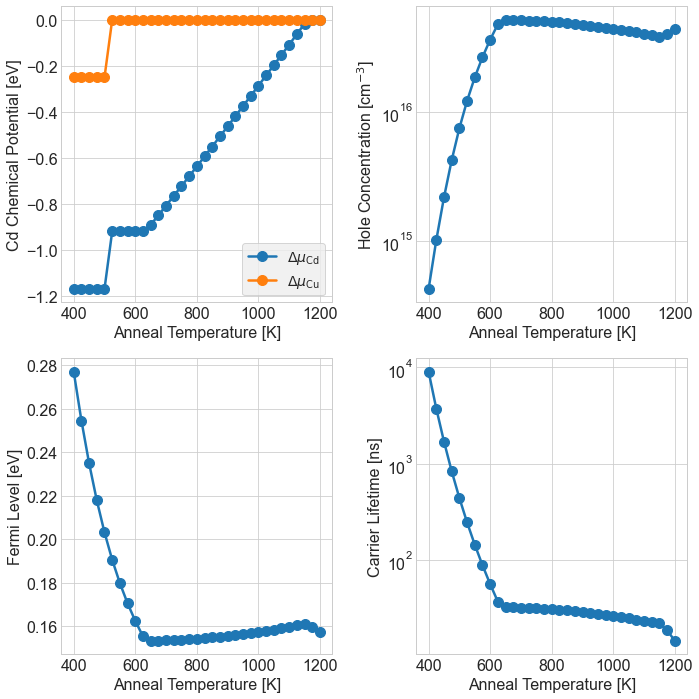

In [21]:
fig = plt.figure(tight_layout=True, figsize=(10,10))
gs = gridspec.GridSpec(2,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

axes[0][0].plot(anneal_temps, Cd_chem_pots, label=r'$\Delta \mu_\mathrm{Cd}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Cd Chemical Potential [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[0][1].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


axes[1][1].plot(anneal_temps, total_lifetimes/1e-9, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('Anneal Temperature [K]')
axes[1][1].set_ylabel(r'Carrier Lifetime [ns]')


plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()

### Global optimization of $\Delta \mu_\mathrm{Cd}$, $\Delta \mu_\mathrm{Cu}$, and anneal temperature using scipy

In [57]:
def objective_func_global(x):
    [muCd, muCu, anneal_temp] = x
    chem_pots = [muCd, 0, H_CdTe-muCd, muCu, 0, 0]
    final_temperature = 300
    
    ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = annealed_quantities(chem_pots, 
                                                                                      final_temperature, 
                                                                                      anneal_temp)
    return (np.abs(1-total_lifetime/1e-8) + np.abs(1-hole_conc/1e16))

H_CdTe = -1.17
H_CuTe = -0.25

cons = ({'type': 'ineq', 'fun': lambda x:  H_CuTe - (H_CdTe-x[0]) - x[1]})
bnds = ((H_CdTe, 0), (None, 0), (300, 1200))
x_init = [H_CdTe, -1, 800]
# optg = optimize.minimize(objective_func_global, x_init, 
#                         method='SLSQP', options={'ftol': 1e-10},
#                         bounds=bnds, constraints=cons)

minimizer_kwargs = {"method": "SLSQP", "bounds": bnds, 
                    "constraints": cons, "options":{'ftol': 1e-10}}
optg = optimize.basinhopping(objective_func_global, x_init, minimizer_kwargs=minimizer_kwargs,
                             niter=100)

print(optg)

/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


                        fun: 3.8053826109719875
 lowest_optimization_result:      fun: 3.8053826109719875
     jac: array([-4.26968417e+00, -1.33878447e+01, -2.26438046e-04])
 message: 'Optimization terminated successfully'
    nfev: 86
     nit: 21
    njev: 21
  status: 0
 success: True
       x: array([   0.,    0., 1200.])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 2946
                        nit: 100
                       njev: 710
                          x: array([   0.,    0., 1200.])


In [58]:
chem_pots = [optg.x[0], 0, H_CdTe-optg.x[0], optg.x[1], 0, 0]
final_temperature = 300

ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = annealed_quantities(chem_pots, 
                                                                                  final_temperature, 
                                                                                  optg.x[2])
print("Cd chemical potential: {:.3f} [eV]".format(optg.x[0]))
print("Cu chemical potential: {:.3f} [eV]".format(optg.x[1]))
print("Anneal Temperature: {:.1f} [K]".format(optg.x[2]))
print("Fermi level: {:.3f} [eV]".format(ef))
print("Hole concentration: {:.3e} [1/cm^3]".format(hole_conc))
print("Carrier lifetime: {:.3f} [ns]".format(total_lifetime/1e-9))

Cd chemical potential: 0.000 [eV]
Cu chemical potential: 0.000 [eV]
Anneal Temperature: 1200.0 [K]
Fermi level: 0.158 [eV]
Hole concentration: 4.345e+16 [1/cm^3]
Carrier lifetime: 14.606 [ns]


### Add in intrinisic defects

Optimize [Cd]:[Te] ratio. Shows narrow tolerance to off-stoichiometry for stable material.

In [72]:
excluded_defects = ["V_Cd+Te_Cd", "Te_int+Te_int", "Te_int+Te_Cd",
                    "As_Te", 
                    "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd",
                    "Cu_Cd+Cd_int", "Cu_Cd+Cu_int"]
                    

defect_thermo = DefectThermodynamics.from_json(os.path.join(PARAMETERS, 'params_CdTe_Wei_FS.json'),
                                                excluded_defects=excluded_defects)
                                                
def objective_func(x, args):
    [muCd, muCu] = x
    chem_pots = [muCd, 0, H_CdTe-muCd, muCu, 0, 0]
    temperature = args[0]
    
    ef = defect_thermo.solve_for_fermi_energy(chem_pots, temperature)
    afs = defect_thermo.atomic_fractions(chem_pots, ef, temperature)
    return afs[0]/afs[2]

H_CdTe = -1.17
H_CuTe = -0.25

temperature = 800

cons = ({'type': 'ineq', 'fun': lambda x:  H_CuTe - (H_CdTe-x[0]) - x[1]})
bnds = ((H_CdTe, 0), (None, 0))
x_init = [H_CdTe, -1]

minimizer_kwargs = {"method": "SLSQP", "bounds": bnds, "args": [temperature],
                    "constraints": cons, "options":{'ftol': 1e-10}}
optg = optimize.basinhopping(objective_func, x_init, minimizer_kwargs=minimizer_kwargs,
                             niter=100)


In [73]:
chem_pots = [optg.x[0], 0, H_CdTe-optg.x[0], optg.x[1], 0, 0]
ef = defect_thermo.solve_for_fermi_energy(chem_pots, temperature)
afs = defect_thermo.atomic_fractions(chem_pots, ef, temperature)

print("Cd chemical potential: {:.3f} [eV]".format(optg.x[0]))
print("Cu chemical potential: {:.3f} [eV]".format(optg.x[1]))
print("Fermi level: {:.3f} [eV]".format(ef))
print("[Cd]:[Te] ratio: {:.6f} [eV]".format(afs[0]/afs[2]))


Cd chemical potential: -0.920 [eV]
Cu chemical potential: -0.000 [eV]
Fermi level: 0.470 [eV]
[Cd]:[Te] ratio: 0.999686 [eV]


Local optimization of $E_\mathrm{Fermi}$ with scipy

Additional capture rates from [Scientific Reports 6, 21712 (2016)](https://www.nature.com/articles/srep21712)

In [33]:
excluded_defects = ["V_Cd+Te_Cd", "Te_int+Te_int", "Te_int+Te_Cd",
                    "As_Te", 
                    "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd",
                    "Cu_Cd+Cd_int", "Cu_Cd+Cu_int"]
                    

defect_thermo = DefectThermodynamics.from_json(os.path.join(PARAMETERS, 'params_CdTe_Wei_FS.json'),
                                                excluded_defects=excluded_defects)

H_CdTe = -1.17
H_CuTe = -0.25
H_CdCl2 = -3.60

def annealed_quantities(chem_pots, final_temperature, anneal_temp):
    ef_anneal = defect_thermo.solve_for_fermi_energy(chem_pots, anneal_temp)
    high_temp_conc = defect_thermo.defect_concentrations(chem_pots, ef_anneal, anneal_temp)
    ef = defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, final_temperature, anneal_temp)
    hole_conc, electron_conc = defect_thermo.charge_carriers(ef, final_temperature)
    low_temp_conc = defect_thermo.redistribute_defect_charge_states(high_temp_conc, ef, final_temperature)
    
    NV_Cd = np.sum(low_temp_conc[0])
    NTe_Cd = np.sum(low_temp_conc[3])
    NCu_Cd = np.sum(low_temp_conc[-4])
    NCu_int = np.sum(low_temp_conc[-3])
    
    Bn_Cd = 1.55e-11
    Bp_Cd = 1.69e-10
    Bn_Cu = 2.55e-10
    Bp_Cu = 6.82e-10
    capture_rates = [Bn_Cd * NV_Cd, Bp_Cd * NTe_Cd,
                     Bn_Cu * NCu_Cd, Bp_Cu * NCu_int]
    total_lifetime = 1/np.sum(capture_rates)
    
    return ef, hole_conc, electron_conc, low_temp_conc, total_lifetime

def objective_func(x, args):
#     [muCd, muCu, muCl] = x
    [muCd, muCu] = x
    muCl = 0
    anneal_temp = args[0]
    chem_pots = [muCd, 0, H_CdTe-muCd, muCu, 0, muCl]
    final_temperature = 300
    
    ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = annealed_quantities(chem_pots, 
                                                                                      final_temperature, 
                                                                                      anneal_temp)

    return ef


# cons = ({'type': 'ineq', 'fun': lambda x:  H_CuTe - (H_CdTe-x[0]) - x[1]},
#         {'type': 'ineq', 'fun': lambda x:  H_CdCl2 - x[0] - 2*x[2]})
# bnds = ((H_CdTe, 0), (-2, 0), (-2, 0))

cons = ({'type': 'ineq', 'fun': lambda x:  H_CuTe - (H_CdTe-x[0]) - x[1]})
bnds = ((H_CdTe, 0), (-2, 0))

anneal_temps = np.arange(400, 1205, 25)
Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
Cl_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)
total_lifetimes = copy.deepcopy(Cd_chem_pots)

# x_init = [H_CdTe, -1, -1]
x_init = [H_CdTe, 0]
for i, ann_temp in enumerate(anneal_temps):
    opt = optimize.minimize(objective_func, x_init, args=[ann_temp], 
                            method='SLSQP', options={'ftol': 1e-10},
                            bounds=bnds, constraints=cons)
    
#     minimizer_kwargs = {"method": "SLSQP", "bounds": bnds, "args": [ann_temp],
#                         "constraints": cons, "options":{'ftol': 1e-10}}
#     opt = optimize.basinhopping(objective_func, x_init, 
#                                 minimizer_kwargs=minimizer_kwargs,
#                                 niter=100)
    x_init = opt.x
    
    Cd_chem_pots[i] = opt.x[0]
    Cu_chem_pots[i] = opt.x[1]
#     Cl_chem_pots[i] = opt.x[2]
    
    print(f' Step {i} | temp {ann_temp} |', opt.x)
    
#     chem_pots = [opt.x[0], 0, H_CdTe-opt.x[0], opt.x[1], 0, opt.x[2]]
    chem_pots = [opt.x[0], 0, H_CdTe-opt.x[0], opt.x[1], 0, 0]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = annealed_quantities(chem_pots, 
                                                                                      final_temperature, 
                                                                                      ann_temp)
    efermis[i] = ef
    hole_concentrations[i] = hole_conc
    total_lifetimes[i] = total_lifetime

 Step 0 | temp 400 | [-1.17 -0.25]
 Step 1 | temp 425 | [-1.17 -0.25]
 Step 2 | temp 450 | [-1.17 -0.25]
 Step 3 | temp 475 | [-1.17 -0.25]
 Step 4 | temp 500 | [-1.17 -0.25]
 Step 5 | temp 525 | [-1.17 -0.25]
 Step 6 | temp 550 | [-1.17 -0.25]
 Step 7 | temp 575 | [-1.17       -0.26460019]
 Step 8 | temp 600 | [-1.17      -0.3034388]
 Step 9 | temp 625 | [-1.17       -0.34174138]
 Step 10 | temp 650 | [-1.17       -0.37958307]
 Step 11 | temp 675 | [-1.17       -0.41701626]
 Step 12 | temp 700 | [-1.17       -0.45407771]
 Step 13 | temp 725 | [-1.17       -0.49079163]
 Step 14 | temp 750 | [-1.17       -0.52716958]
 Step 15 | temp 775 | [-1.17       -0.56320624]
 Step 16 | temp 800 | [-1.17       -0.59886868]
 Step 17 | temp 825 | [-1.17       -0.63407486]
 Step 18 | temp 850 | [-1.17       -0.66865502]
 Step 19 | temp 875 | [-1.17       -0.70229057]
 Step 20 | temp 900 | [-1.17       -0.73443966]
 Step 21 | temp 925 | [-1.17       -0.76429541]
 Step 22 | temp 950 | [-1.17       -0.79

/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


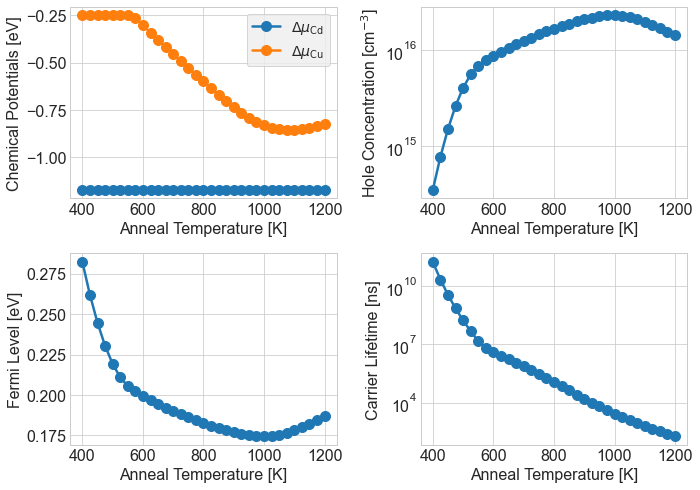

In [35]:
fig = plt.figure(tight_layout=True, figsize=(10,10))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

axes[0][0].plot(anneal_temps, Cd_chem_pots, label=r'$\Delta \mu_\mathrm{Cd}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
# axes[0][0].plot(anneal_temps, Cl_chem_pots, label=r'$\Delta \mu_\mathrm{Cl}$',
#                 marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Chemical Potentials [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[0][1].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


axes[1][1].plot(anneal_temps, total_lifetimes/1e-9, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('Anneal Temperature [K]')
axes[1][1].set_ylabel(r'Carrier Lifetime [ns]')


plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()

## Example using NLopt

See [nlopt's documentation](https://nlopt.readthedocs.io/en/latest/) for additional details.

In [77]:
import nlopt

excluded_defects = ["V_Cd+Te_Cd", "Te_int+Te_int", "Te_int+Te_Cd",
                    "As_Te", 
                    "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd",
                    "Cu_Cd+Cd_int", "Cu_Cd+Cu_int"]

defect_thermo = DefectThermodynamics.from_json(os.path.join(PARAMETERS, 'params_CdTe_Wei_FS.json'),
                                                excluded_defects=excluded_defects)

H_CdTe = -1.17
H_CuTe = -0.25
H_CdCl2 = -3.60

def annealed_quantities(chem_pots, final_temperature, anneal_temp):
    ef_anneal = defect_thermo.solve_for_fermi_energy(chem_pots, anneal_temp)
    high_temp_conc = defect_thermo.defect_concentrations(chem_pots, ef_anneal, anneal_temp)
    ef = defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, final_temperature, anneal_temp)
    hole_conc, electron_conc = defect_thermo.charge_carriers(ef, final_temperature)
    low_temp_conc = defect_thermo.redistribute_defect_charge_states(high_temp_conc, ef, final_temperature)
    
    return ef, hole_conc, electron_conc, low_temp_conc

def objective_func(x, grad, anneal_temp):
#     [muCd, muCu, muCl] = x
    [muCd, muCu] = x
    muCl = 0
    chem_pots = [muCd, 0, H_CdTe-muCd, muCu, 0, muCl]
    final_temperature = 300
    
    ef, hole_conc, electron_conc, low_temp_conc = annealed_quantities(chem_pots, 
                                                                      final_temperature, 
                                                                      anneal_temp)
    return ef


upper_bounds = [0, 0]
lower_bounds = [H_CdTe, -2.0]
cons = lambda x, grad:  H_CuTe - (H_CdTe-x[0]) - x[1]


anneal_temps = np.arange(400, 1205, 100)
Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
Cl_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)
total_lifetimes = copy.deepcopy(Cd_chem_pots)

# x_init = [H_CdTe, -1, -1]
x_init = np.array([H_CdTe, -0.25])
nvar = len(x_init)
for i, ann_temp in enumerate(anneal_temps):
    
    obj_func = lambda x, grad: objective_func(x, grad, ann_temp)

    opt = nlopt.opt(nlopt.GN_ISRES, nvar)

    opt.set_min_objective(obj_func)

    local_opt = nlopt.opt(nlopt.LN_COBYLA, nvar)
    local_opt.set_ftol_rel(1e-1)

    opt.set_local_optimizer(local_opt)


    opt.set_lower_bounds(lower_bounds)
    opt.set_upper_bounds(upper_bounds)
    opt.add_inequality_constraint(cons)
    
#     opt.set_xtol_rel(1e-4)
    opt.set_maxeval(1000)

    x1 = opt.optimize(x_init)
    x_init[:] = x1
    minf = opt.last_optimum_value()
        
    
    Cd_chem_pots[i] = x1[0]
    Cu_chem_pots[i] = x1[1]
#     Cl_chem_pots[i] = x1[2]
    
    print(f' Step {i} | temp {ann_temp} |', x1)
    
#     chem_pots = [x1[0], 0, H_CdTe-x1[0], x1[1], 0, x1[2]]
    chem_pots = [x1[0], 0, H_CdTe-x1[0], x1[1], 0, 0]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc = annealed_quantities(chem_pots, 
                                                                      final_temperature, 
                                                                      ann_temp)
    efermis[i] = ef
    hole_concentrations[i] = hole_conc



 Step 0 | temp 400 | [-1.16985714 -0.03613849]
 Step 1 | temp 500 | [-1.16873259 -0.07983401]
 Step 2 | temp 600 | [-1.16803154 -0.19869425]
 Step 3 | temp 700 | [-1.16803154 -0.19869425]
 Step 4 | temp 800 | [-1.16774741 -0.23195682]
 Step 5 | temp 900 | [-1.16489267 -0.00491937]
 Step 6 | temp 1000 | [-1.16489267 -0.00491937]
 Step 7 | temp 1100 | [-1.16489267 -0.00491937]
 Step 8 | temp 1200 | [-1.16489267 -0.00491937]


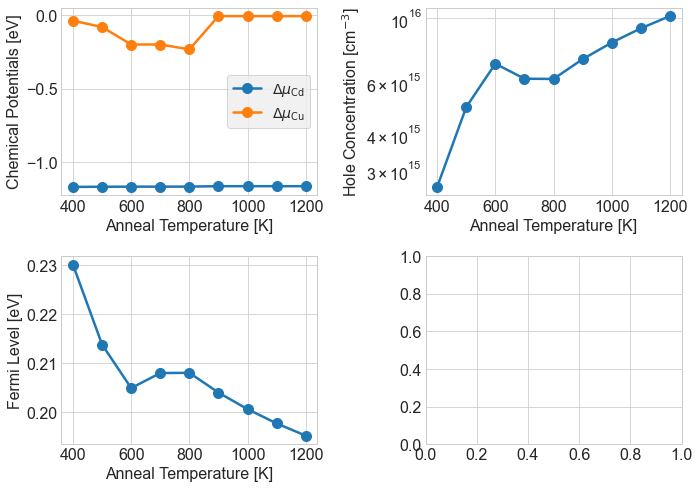

In [78]:
fig = plt.figure(tight_layout=True, figsize=(10,10))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(2)]

axes[0][0].plot(anneal_temps, Cd_chem_pots, label=r'$\Delta \mu_\mathrm{Cd}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
# axes[0][0].plot(anneal_temps, Cl_chem_pots, label=r'$\Delta \mu_\mathrm{Cl}$',
#                 marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Chemical Potentials [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[0][1].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()

# Examples using Pymoo (multiobjective)

See [pymoo's documentation](https://pymoo.org/) for additional details.

In [77]:
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.age import AGEMOEA
from pymoo.algorithms.soo.nonconvex.pattern_search import PatternSearch
from pymoo.optimize import minimize
from pymoo.factory import get_termination
from pymoo.decomposition.asf import ASF
from pymoo.core.problem import starmap_parallelized_eval
from multiprocessing.pool import ThreadPool


class FermiDopants(ElementwiseProblem):
    def __init__(self, anneal_temp, **kwargs):
        
        self.anneal_temp = anneal_temp
        self.H_CdTe = -1.17
        self.H_CuTe = -0.25
        self.H_Cd3As2 = -0.46
        self.H_CdCl2 = -3.60
        
        upper_bounds = np.array([0, 0, 0])
        lower_bounds = np.array([self.H_CdTe, -5.0, -5.0])

        excluded_defects = ["As_Te",]
        self.defect_thermo = DefectThermodynamics.from_json(os.path.join(PARAMETERS, 'params_CdTe_Wei_FS.json'),
                                                            excluded_defects=excluded_defects)

        super().__init__(n_var=3, n_obj=2, n_constr=3, xl=lower_bounds, xu=upper_bounds, **kwargs)
        
    def _evaluate(self, x, out, *args, **kwargs):
        chem_pots = [x[0], 0, self.H_CdTe-x[0], x[1], 0, x[2]]
        final_temperature = 300
    
        ef, hole_conc, electron_conc, low_temp_conc = self.annealed_quantities(chem_pots, 
                                                                               final_temperature, 
                                                                               self.anneal_temp)
        
        g1 = -(self.H_CuTe - (self.H_CdTe-x[0]) - x[1])
        g2 = -(self.H_CdCl2 - x[0] - 2*x[2])
        g3 = np.log( 1e16 / np.sum(low_temp_conc[9:13]) )
        g4 = np.log( 1e16 / np.sum(low_temp_conc[13:]) )
        g5 = - np.log( 1e19 / np.sum(low_temp_conc[13:]) )
       
        # f1 = ef
        # f2 = np.abs(np.log(np.sum(low_temp_conc[6:10])/1e12))
        
        f1 = ef
        f2 = np.abs( np.log( 1e16 / np.sum(low_temp_conc[13:]) )) / 10
        f3 = np.abs( np.log( 1e12 / np.sum(low_temp_conc[9:13]) )) / 10
                           
        out['F'] = [f1, f3]
        out['G'] = [g1, g2, g4]
        
    def annealed_quantities(self, chem_pots, final_temperature, anneal_temp):
        ef_anneal = self.defect_thermo.solve_for_fermi_energy(chem_pots,
                                                              anneal_temp)
        high_temp_conc = self.defect_thermo.defect_concentrations(chem_pots, 
                                                                  ef_anneal,
                                                                  anneal_temp)
        ef = self.defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, 
                                                                       final_temperature, 
                                                                       anneal_temp)
        hole_conc, electron_conc = self.defect_thermo.charge_carriers(ef,
                                                                      final_temperature)
        low_temp_conc = self.defect_thermo.redistribute_defect_charge_states(high_temp_conc, 
                                                                             ef, 
                                                                             final_temperature)

        return ef, hole_conc, electron_conc, low_temp_conc
    
    
n_threads = 4
pool = ThreadPool(n_threads)

algorithm = AGEMOEA(pop_size=100, return_least_infeasible=False)
# algorithm = PatternSearch(return_least_infeasible=True)
termination = get_termination("n_gen", 25)


anneal_temps = np.arange(500, 1205, 100)

H_CdTe = -1.17
H_CuTe = -0.25
H_Cd3As2 = -0.46
H_CdCl2 = -3.60

Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
Cl_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)
Cu_concentrations = copy.deepcopy(Cd_chem_pots)
Cl_concentrations = copy.deepcopy(Cd_chem_pots)

for i, ann_temp in enumerate(anneal_temps):

    problem = FermiDopants(anneal_temp=ann_temp,
                           runner=pool.starmap, 
                           func_eval=starmap_parallelized_eval)
    
    res = minimize(problem,
                   algorithm,
                   termination,
#                    seed=1,
                   save_history=True,
                   verbose=True)
    
    X = res.X
    F = res.F
#     print(res.X)
#     print(res.F)
    
    approx_ideal = F.min(axis=0)
    approx_nadir = F.max(axis=0)
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
    decomp = ASF()
    weights = np.array([0.2, 0.8])
    j = decomp.do(nF, 1/weights).argmin()

    Cd_chem_pots[i] = X[j,0]
    Cu_chem_pots[i] = X[j,1]
    Cl_chem_pots[i] = X[j,2]
    
    print(f' Step {i} | temp {ann_temp} | params {X[j]}')
    print(f' -> Loss {F[j]}')
    
    chem_pots = [X[j,0], 0, H_CdTe-X[j,0], X[j,1], 0, X[j,2]]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc = problem.annealed_quantities(chem_pots, 
                                                                              final_temperature, 
                                                                              ann_temp)
    efermis[i] = ef
    hole_concentrations[i] = hole_conc
    Cu_concentrations[i] = np.sum(low_temp_conc[13:])
    Cl_concentrations[i] = np.sum(low_temp_conc[9:13])


n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.549096363 |  5.37735E+01 |       1 |            - |            -


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/pymoo/algorithms/moo/age.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_val = np.iinfo(np.int).max


    2 |     200 |  0.00000E+00 |  1.75664E+01 |       1 |  3.912700298 |        ideal
    3 |     300 |  0.00000E+00 |  4.906861691 |       2 |  1.000000000 |        ideal


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/pymoo/algorithms/moo/age.py:158: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  selected = np.zeros(m, dtype=np.bool)


    4 |     400 |  0.00000E+00 |  2.195318007 |       3 |  0.002095532 |            f
    5 |     500 |  0.00000E+00 |  1.017319896 |       2 |  6.35506E+02 |        ideal
    6 |     600 |  0.00000E+00 |  0.147195876 |       6 |  0.743932169 |        ideal
    7 |     700 |  0.00000E+00 |  0.002326157 |       6 |  0.158467698 |        ideal
    8 |     800 |  0.00000E+00 |  0.00000E+00 |      10 |  0.059867502 |            f
    9 |     900 |  0.00000E+00 |  0.00000E+00 |      11 |  0.078386921 |            f
   10 |    1000 |  0.00000E+00 |  0.00000E+00 |      12 |  0.041374068 |        ideal
   11 |    1100 |  0.00000E+00 |  0.00000E+00 |       7 |  0.002687838 |        nadir
   12 |    1200 |  0.00000E+00 |  0.00000E+00 |       8 |  0.043011383 |            f
   13 |    1300 |  0.00000E+00 |  0.00000E+00 |      10 |  0.013542879 |            f
   14 |    1400 |  0.00000E+00 |  0.00000E+00 |      12 |  0.465571442 |        nadir
   15 |    1500 |  0.00000E+00 |  0.00000E+00 |      1

   12 |    1200 |  0.00000E+00 |  0.00000E+00 |       6 |  0.005437956 |        ideal
   13 |    1300 |  0.00000E+00 |  0.00000E+00 |       6 |  0.00000E+00 |            f
   14 |    1400 |  0.00000E+00 |  0.00000E+00 |       8 |  0.014905853 |        nadir
   15 |    1500 |  0.00000E+00 |  0.00000E+00 |       8 |  0.003688375 |        ideal
   16 |    1600 |  0.00000E+00 |  0.00000E+00 |       9 |  0.007982419 |        nadir
   17 |    1700 |  0.00000E+00 |  0.00000E+00 |      12 |  0.025645389 |            f
   18 |    1800 |  0.00000E+00 |  0.00000E+00 |      12 |  0.690190347 |        nadir
   19 |    1900 |  0.00000E+00 |  0.00000E+00 |      11 |  0.009547235 |            f
   20 |    2000 |  0.00000E+00 |  0.00000E+00 |      14 |  0.000778939 |            f
   21 |    2100 |  0.00000E+00 |  0.00000E+00 |      13 |  0.004727148 |            f
   22 |    2200 |  0.00000E+00 |  0.00000E+00 |      18 |  0.086535303 |        nadir
   23 |    2300 |  0.00000E+00 |  0.00000E+00 |      1

   20 |    2000 |  0.00000E+00 |  0.00000E+00 |       9 |  0.003528884 |            f
   21 |    2100 |  0.00000E+00 |  0.00000E+00 |      10 |  1.98399E+01 |        nadir
   22 |    2200 |  0.00000E+00 |  0.00000E+00 |      12 |  1.334216288 |        nadir
   23 |    2300 |  0.00000E+00 |  0.00000E+00 |      15 |  0.384695172 |        nadir
   24 |    2400 |  0.00000E+00 |  0.00000E+00 |       8 |  0.085299225 |        nadir
   25 |    2500 |  0.00000E+00 |  0.00000E+00 |       4 |  0.004806394 |        nadir
 Step 6 | temp 1100 | params [-1.16998094 -1.2547982  -2.09820821]
 -> Loss [1.44559217e-01 4.10605731e-05]
n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.00000E+00 |  1.27788E+01 |       2 |            - |            -
    2 |     200 |  0.00000E+00 |  0.910607280 |       5 |  0.144133174 |        ideal
    3 |     300 |  0.00000E+00 |  0.00000E+00 |       6 |  0.052802475 |        ideal
    4 |     400 |  0.00000E+00 |

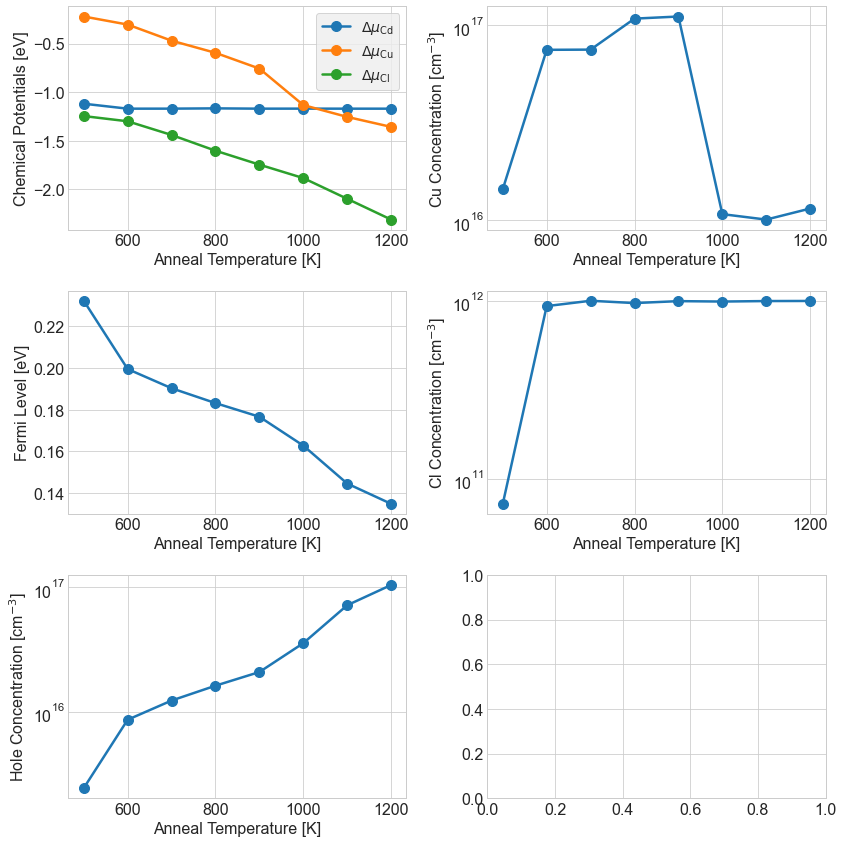

In [78]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(3)]


axes[0][0].plot(anneal_temps, Cd_chem_pots, label=r'$\Delta \mu_\mathrm{Cd}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cl_chem_pots, label=r'$\Delta \mu_\mathrm{Cl}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Chemical Potentials [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[2][0].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[2][0].set_yscale('log')
axes[2][0].set_xlabel('Anneal Temperature [K]')
axes[2][0].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


axes[0][1].plot(anneal_temps, Cu_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Cu Concentration [cm$^{-3}$]')


axes[1][1].plot(anneal_temps, Cl_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('Anneal Temperature [K]')
axes[1][1].set_ylabel(r'Cl Concentration [cm$^{-3}$]')



plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()

At least one feasible solution in Generation 0 after 100 evaluations.
Whole population feasible in Generation 1 after 200 evaluations.


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


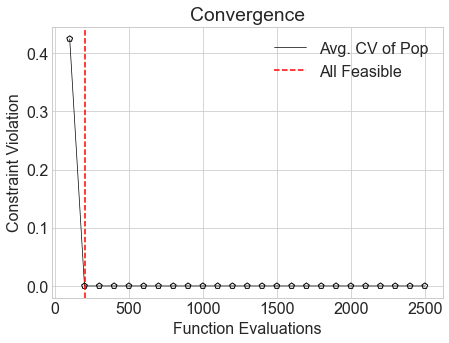

In [73]:
n_evals = []             # corresponding number of function evaluations\
hist_F = []              # the objective space values in each generation
hist_cv = []             # constraint violation in each generation
hist_cv_avg = []         # average constraint violation in the whole population

hist = res.history
for algo in hist:

    # store the number of function evaluations
    n_evals.append(algo.evaluator.n_eval)

    # retrieve the optimum from the algorithm
    opt = algo.opt

    # store the least contraint violation and the average in each population
    hist_cv.append(opt.get("CV").min())
    hist_cv_avg.append(algo.pop.get("CV").mean())

    # filter out only the feasible and append and objective space values
    feas = np.where(opt.get("feasible"))[0]
    hist_F.append(opt.get("F")[feas])

k = np.where(np.array(hist_cv) <= 0.0)[0].min()
print(f"At least one feasible solution in Generation {k} after {n_evals[k]} evaluations.")

# replace this line by `hist_cv` if you like to analyze the least feasible optimal solution and not the population
vals = hist_cv_avg

k = np.where(np.array(vals) <= 0.0)[0].min()
print(f"Whole population feasible in Generation {k} after {n_evals[k]} evaluations.")

plt.figure(figsize=(7, 5))
plt.plot(n_evals, vals,  color='black', lw=0.7, label="Avg. CV of Pop")
plt.scatter(n_evals, vals,  facecolor="none", edgecolor='black', marker="p")
plt.axvline(n_evals[k], color="red", label="All Feasible", linestyle="--")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Constraint Violation")
plt.legend()
plt.show()
plt.close()

from pymoo.util.running_metric import RunningMetric

running = RunningMetric(delta_gen=10,
                        n_plots=5,
                        only_if_n_plots=True,
                        key_press=False,
                        do_show=True)

for algorithm in res.history:
    running.notify(algorithm)


In [64]:
res.F

array([[0.18271195, 0.37835497],
       [0.24057209, 0.19430237],
       [0.24158435, 0.19134093],
       [0.24184918, 0.1867347 ],
       [0.20492925, 0.20387886],
       [0.24158444, 0.18943686],
       [0.19120352, 0.27408199],
       [0.18326267, 0.34328006],
       [0.20809594, 0.20305239],
       [0.18805081, 0.29697671],
       [0.1911721 , 0.27410291],
       [0.2414328 , 0.19173799],
       [0.18266138, 0.47656677],
       [0.20221198, 0.20992816],
       [0.18274777, 0.36006251],
       [0.2097045 , 0.19782416],
       [0.19568508, 0.26586113],
       [0.1989384 , 0.25162099],
       [0.24168622, 0.18825993],
       [0.20358869, 0.20898135],
       [0.18552051, 0.33322906],
       [0.19021798, 0.27977744],
       [0.18263297, 0.67182592],
       [0.1866162 , 0.31783251],
       [0.1990166 , 0.2472887 ],
       [0.18752275, 0.3003852 ],
       [0.20209686, 0.23436716],
       [0.18268853, 0.38032232],
       [0.18410851, 0.33898731],
       [0.18634699, 0.32021552],
       [0.

In [60]:
X = res.X
F = res.F
#     print(res.X)
#     print(res.F)

approx_ideal = F.min(axis=0)
approx_nadir = F.max(axis=0)
nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
decomp = ASF()
weights = np.array([0.01, 0.01, 0.98])
j = decomp.do(nF, 1/weights).argmin()

print(X[j])
print(F[j])

[-0.87629642 -0.06303653 -1.37212222]
[0.26481642 0.59350791 0.20581592]


In [83]:
from pymoo.core.problem import Problem, ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.age import AGEMOEA
from pymoo.algorithms.soo.nonconvex.pattern_search import PatternSearch
from pymoo.optimize import minimize
from pymoo.factory import get_termination
from pymoo.decomposition.asf import ASF
from pymoo.core.problem import starmap_parallelized_eval
from multiprocessing.pool import ThreadPool


class FermiDopants(ElementwiseProblem):
    def __init__(self, anneal_temp, **kwargs):
        
        self.anneal_temp = anneal_temp
        self.H_CdTe = -1.17
        self.H_CuTe = -0.25
        self.H_Cd3As2 = -0.46
        self.H_CdCl2 = -3.60
        
        upper_bounds = np.array([0, 0])
        lower_bounds = np.array([self.H_CdTe, -2.0])

        excluded_defects = [#"V_Cd", "V_Te", "Cd_Te", "Te_Cd", "Cd_int", "Te_int",
                            "V_Cd+Te_Cd", "Te_int+Te_int", "Te_int+Te_Cd",
                            "As_Te", 
                            "Cl_Te", "Cl_int", "Cl_Te+V_Cd", "Cl_int+V_Cd",
                            "Cu_Cd+Cd_int", "Cu_Cd+Cu_int"]
        self.defect_thermo = DefectThermodynamics.from_json(os.path.join(PARAMETERS, 'params_CdTe_Wei_FS.json'),
                                                            excluded_defects=excluded_defects)

        super().__init__(n_var=2, n_obj=2, n_constr=2, xl=lower_bounds, xu=upper_bounds, **kwargs)
        
    def _evaluate(self, x, out, *args, **kwargs):
        chem_pots = [x[0], 0, self.H_CdTe-x[0], x[1], 0, 0]
        final_temperature = 300
    
        ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = self.annealed_quantities(chem_pots, 
                                                                                   final_temperature, 
                                                                                   self.anneal_temp)

        g1 = -(self.H_CuTe - (self.H_CdTe-x[0]) - x[1])
#         g2 = -(self.H_CdCl2 - x[0] - 2*x[2])
        g3 = np.log( 1e16 / np.sum(low_temp_conc[6:]) )
#         g4 = np.log( 1e16 / np.sum(low_temp_conc[13:]) )
#         g5 = - np.log( 1e19 / np.sum(low_temp_conc[13:]) )
       
        # f1 = ef
        # f2 = np.abs(np.log(np.sum(low_temp_conc[6:10])/1e12))
        
        f1 = ef
#         f2 = np.abs( np.log( 1e16 / np.sum(low_temp_conc[13:]) )) / 10
#         f3 = np.abs( np.log( 1e12 / np.sum(low_temp_conc[9:13]) )) / 10
        f4 = -np.log(total_lifetime)
                           
        out['F'] = [f1, f4]
        out['G'] = [g1, g3]
        
    def annealed_quantities(self, chem_pots, final_temperature, anneal_temp):
        ef_anneal = self.defect_thermo.solve_for_fermi_energy(chem_pots,
                                                              anneal_temp)
        high_temp_conc = self.defect_thermo.defect_concentrations(chem_pots, 
                                                                  ef_anneal,
                                                                  anneal_temp)
        ef = self.defect_thermo.solve_for_non_equilibrium_fermi_energy(chem_pots, 
                                                                       final_temperature, 
                                                                       anneal_temp)
        hole_conc, electron_conc = self.defect_thermo.charge_carriers(ef,
                                                                      final_temperature)
        low_temp_conc = self.defect_thermo.redistribute_defect_charge_states(high_temp_conc, 
                                                                             ef, 
                                                                             final_temperature)
        
        NCu_Cd = np.sum(low_temp_conc[6])
        NCu_int = np.sum(low_temp_conc[7])
    
        Bn = 2.55e-10
        Bp = 6.82e-10
        capture_rates = [Bn * NCu_Cd, Bp * NCu_int]
        total_lifetime = 1/np.sum(capture_rates)

        return ef, hole_conc, electron_conc, low_temp_conc, total_lifetime
    
    
n_threads = 4
pool = ThreadPool(n_threads)

algorithm = AGEMOEA(pop_size=100, return_least_infeasible=True)
# algorithm = PatternSearch(return_least_infeasible=True)
termination = get_termination("n_gen", 10)


anneal_temps = np.arange(500, 1205, 100)

H_CdTe = -1.17
H_CuTe = -0.25
H_Cd3As2 = -0.46
H_CdCl2 = -3.60

Cd_chem_pots = np.zeros(anneal_temps.shape)
Cu_chem_pots = copy.deepcopy(Cd_chem_pots)
Cl_chem_pots = copy.deepcopy(Cd_chem_pots)
efermis = copy.deepcopy(Cd_chem_pots)
lifetimes = copy.deepcopy(Cd_chem_pots)
hole_concentrations = copy.deepcopy(Cd_chem_pots)
Cu_concentrations = copy.deepcopy(Cd_chem_pots)
Cl_concentrations = copy.deepcopy(Cd_chem_pots)

for i, ann_temp in enumerate(anneal_temps):

    problem = FermiDopants(anneal_temp=ann_temp,
                           runner=pool.starmap, 
                           func_eval=starmap_parallelized_eval)
    
    res = minimize(problem,
                   algorithm,
                   termination,
#                    seed=1,
                   save_history=True,
                   verbose=True)
    
    X = res.X
    F = res.F
#     print(res.X)
#     print(res.F)
    
    approx_ideal = F.min(axis=0)
    approx_nadir = F.max(axis=0)
    nF = (F - approx_ideal) / (approx_nadir - approx_ideal)
    decomp = ASF()
    weights = np.array([0.2, 0.8])
    j = decomp.do(nF, 1/weights).argmin()

    Cd_chem_pots[i] = X[j,0]
    Cu_chem_pots[i] = X[j,1]
    
    print(f' Step {i} | temp {ann_temp} | params {X[j]}')
    print(f' -> Loss {F[j]}')
    
    chem_pots = [X[j,0], 0, H_CdTe-X[j,0], X[j,1], 0, 0]
    final_temperature = 300
    ef, hole_conc, electron_conc, low_temp_conc, total_lifetime = problem.annealed_quantities(chem_pots, 
                                                                                  final_temperature, 
                                                                                  ann_temp)
    efermis[i] = ef
    lifetimes[i] = total_lifetime
    hole_concentrations[i] = hole_conc
    Cu_concentrations[i] = np.sum(low_temp_conc[6:])


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/pymoo/algorithms/moo/age.py:93: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  max_val = np.iinfo(np.int).max


n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.00000E+00 |  2.02355E+01 |       1 |            - |            -
    2 |     200 |  0.00000E+00 |  6.763072776 |       1 |  1.070843743 |        ideal
    3 |     300 |  0.00000E+00 |  2.083414927 |       1 |  0.205057299 |        ideal
    4 |     400 |  0.00000E+00 |  0.302051741 |       1 |  0.00000E+00 |            f
    5 |     500 |  0.00000E+00 |  0.011401776 |       1 |  0.00000E+00 |            f


/opt/anaconda3/envs/qcqc/lib/python3.7/site-packages/pymoo/algorithms/moo/age.py:158: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  selected = np.zeros(m, dtype=np.bool)


    6 |     600 |  0.00000E+00 |  0.00000E+00 |       4 |  0.169580708 |        ideal
    7 |     700 |  0.00000E+00 |  0.00000E+00 |       5 |  0.130322239 |        ideal
    8 |     800 |  0.00000E+00 |  0.00000E+00 |       6 |  0.004888458 |            f
    9 |     900 |  0.00000E+00 |  0.00000E+00 |       9 |  0.069361858 |            f
   10 |    1000 |  0.00000E+00 |  0.00000E+00 |      11 |  0.006467877 |            f
 Step 0 | temp 500 | params [-1.14076324 -0.25724701]
 -> Loss [ 0.2299621  14.77321019]
n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |     100 |  0.00000E+00 |  1.42984E+01 |       3 |            - |            -
    2 |     200 |  0.00000E+00 |  3.155913447 |       4 |  0.197395235 |        ideal
    3 |     300 |  0.00000E+00 |  0.156337356 |       3 |  0.139523373 |        ideal
    4 |     400 |  0.00000E+00 |  0.00000E+00 |       4 |  0.096750390 |        ideal
    5 |     500 |  0.00000E+00 |  0.00000E+00 |    

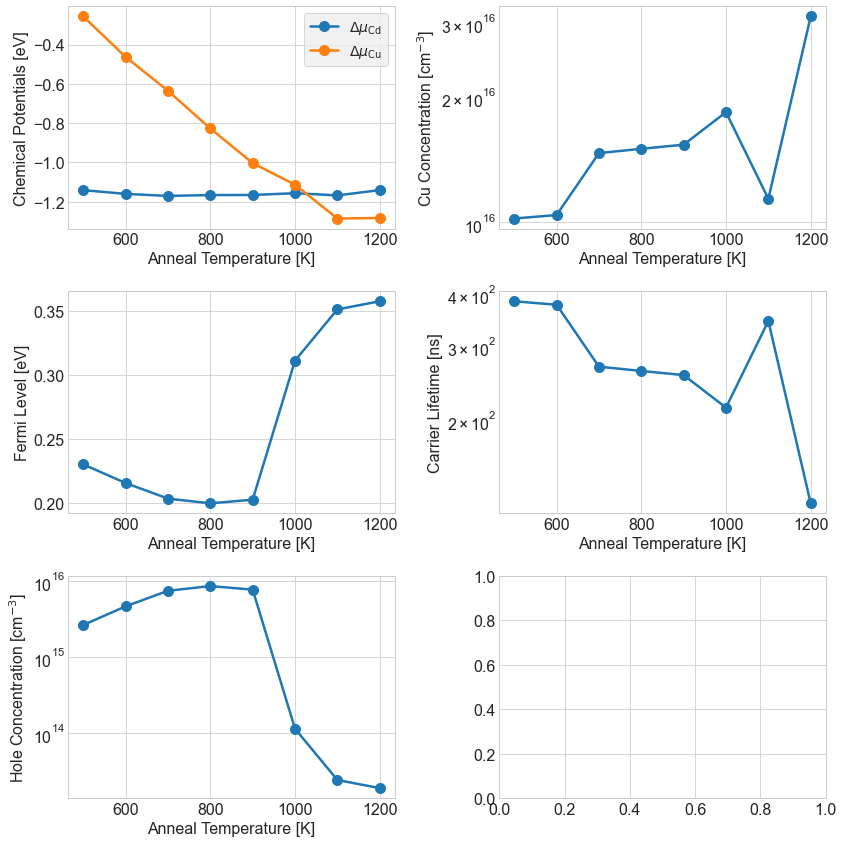

In [84]:
fig = plt.figure(tight_layout=True, figsize=(12,12))
gs = gridspec.GridSpec(3,2)

axes = [[fig.add_subplot(gs[i, j]) for j in range(2)] for i in range(3)]


axes[0][0].plot(anneal_temps, Cd_chem_pots, label=r'$\Delta \mu_\mathrm{Cd}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].plot(anneal_temps, Cu_chem_pots, label=r'$\Delta \mu_\mathrm{Cu}$',
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
# axes[0][0].plot(anneal_temps, Cl_chem_pots, label=r'$\Delta \mu_\mathrm{Cl}$',
#                 marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][0].legend(loc='best', frameon=True, facecolor=light_grey, 
                  prop={'size': 14}, ncol=1)
axes[0][0].set_xlabel('Anneal Temperature [K]')
axes[0][0].set_ylabel('Chemical Potentials [eV]')


axes[1][0].plot(anneal_temps, efermis, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][0].set_xlabel('Anneal Temperature [K]')
axes[1][0].set_ylabel('Fermi Level [eV]')


axes[2][0].plot(anneal_temps, hole_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[2][0].set_yscale('log')
axes[2][0].set_xlabel('Anneal Temperature [K]')
axes[2][0].set_ylabel(r'Hole Concentration [cm$^{-3}$]')


axes[0][1].plot(anneal_temps, Cu_concentrations, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[0][1].set_yscale('log')
axes[0][1].set_xlabel('Anneal Temperature [K]')
axes[0][1].set_ylabel(r'Cu Concentration [cm$^{-3}$]')


axes[1][1].plot(anneal_temps, lifetimes/1e-9, label=None,
                marker='o', markersize=10, linestyle='-', linewidth=2.5)
axes[1][1].set_yscale('log')
axes[1][1].set_xlabel('Anneal Temperature [K]')
axes[1][1].set_ylabel(r'Carrier Lifetime [ns]')



plt.rc('font', **font)
plt.tight_layout()
plt.show()
plt.close()